<center><h5> Data Science For Suppy Chain & Operations </h5></center>
<center><h3> Cours 4 </h3></center>
<center><h1> Apprentissage non supervisé </h1></center>

* Ce notebook contient des exemples d'application de l'**ACP** et de l'algorithme de **clustering K-means** sur le jeu de données du cas d'usage fil rouge *(prédiction des ventes des magasins)*.
* Nous travaillerons sur le jeu de données obtenu à l'issu du cours 2 (cf Notebook 2), sur lequel nous appliquerons quelques transformations additionnelles.

# 0. Chargement et préparation des données

In [1]:
import datetime
import numpy as np
import pandas as pd
## On peut choisir le nombre max de lignes/colonnes à voir
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes = True)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Lecture du fichier
path = r'C:/Users/HP/Desktop/data science sc/cours 3/data.csv'
df = pd.read_csv(path, parse_dates = ["Date"])
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Customers,Sales,Avg_Sales_Per_Customer,Day,Month,Year,CompetitionOpenSince,Promo2Since
0,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-01,2,0,0,a,1,0,0,NaN,1,1,2013,2008-09-01 00:00:00,0
1,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-02,3,1,0,0,1,668,5530,8.28,2,1,2013,2008-09-01 00:00:00,0
2,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-03,4,1,0,0,1,578,4327,7.49,3,1,2013,2008-09-01 00:00:00,0
3,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-04,5,1,0,0,1,619,4486,7.25,4,1,2013,2008-09-01 00:00:00,0
4,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-05,6,1,0,0,1,635,4997,7.87,5,1,2013,2008-09-01 00:00:00,0


In [3]:
# Ajout des colonnes : DaysSincePromo2 et DaysSinceCompetition

df["Promo2Since"] = pd.to_datetime(df["Promo2Since"], errors='coerce')
df["DaysSincePromo2"] = (df["Date"] - df["Promo2Since"]).dt.days

df["CompetitionOpenSince"] = pd.to_datetime(df["CompetitionOpenSince"], errors='coerce')
df["DaysSinceCompetition"] = (df["Date"] - df["CompetitionOpenSince"]).dt.days

In [5]:
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Customers,Sales,Avg_Sales_Per_Customer,Day,Month,Year,CompetitionOpenSince,Promo2Since,DaysSincePromo2,DaysSinceCompetition
0,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-01,2,0,0,a,1,0,0,NaN,1,1,2013,2008-09-01,NaT,NaN,"1,583.00"
1,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-02,3,1,0,0,1,668,5530,8.28,2,1,2013,2008-09-01,NaT,NaN,"1,584.00"
2,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-03,4,1,0,0,1,578,4327,7.49,3,1,2013,2008-09-01,NaT,NaN,"1,585.00"
3,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-04,5,1,0,0,1,619,4486,7.25,4,1,2013,2008-09-01,NaT,NaN,"1,586.00"
4,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0,2013-01-05,6,1,0,0,1,635,4997,7.87,5,1,2013,2008-09-01,NaT,NaN,"1,587.00"


In [6]:
# Pour remplacer les valeurs manquantes dans les deux nouvelles colonnes :
# --> des valeurs aléatoires, issues d'une loi normale cenrée autour de la médianne des valeurs non nulles

rand_PromoSince = [df["DaysSincePromo2"].median()]*len(df)
rand_PromoSince = [x + np.random.normal(0, 200) for x in rand_PromoSince]
df["DaysSincePromo2"] = df["DaysSincePromo2"].fillna(pd.Series(rand_PromoSince))

rand_CompetitionSince = [df["DaysSinceCompetition"].median()]*len(df)
rand_CompetitionSince = [x + np.random.normal(0, 200) for x in rand_CompetitionSince]
df["DaysSinceCompetition"] = df["DaysSinceCompetition"].fillna(pd.Series(rand_CompetitionSince))

**Pour la suite du Notebook, nous allons construire un jeu de données à la maille magasin (1 ligne = 1 magasin), à partir des données descriptives des magasins et des historiques des ventes entre 01/2013 et 07/2015.**

In [7]:
## Extraire les infos "statiques" sur les magasins (on aurait pu relire simplement le fichier store.csv aussi)
data = df[df["Date"]==pd.datetime(year=2015, month=7, day=31)]
data = data[[
    "Store",
    "StoreType",
    "Assortment",
    "CompetitionDistance",
    "DaysSinceCompetition",
    "Promo2",
    "DaysSincePromo2",
    "PromoInterval",
]]

In [8]:
data

,Store,StoreType,Assortment,CompetitionDistance,DaysSinceCompetition,Promo2,DaysSincePromo2,PromoInterval
941,1,c,a,"1,270.00","2,524.00",0,541.08,0
1883,2,a,a,570.00,"2,829.00",1,"1,950.00","Jan,Apr,Jul,Oct"
2825,3,a,a,"14,130.00","3,164.00",1,"1,579.00","Jan,Apr,Jul,Oct"
3767,4,c,c,620.00,"2,159.00",0,748.86,0
4709,5,a,a,"29,910.00",121.00,0,816.97,0
...,...,...,...,...,...,...,...,...
1013440,1111,a,a,"1,900.00",425.00,1,725.00,"Jan,Apr,Jul,Oct"
1014382,1112,c,c,"1,880.00","3,408.00",0,461.24,0
1015324,1113,a,c,"9,260.00","1,477.41",0,587.20,0
1016266,1114,a,c,870.00,"16,647.00",0,"1,123.93",0


Nous allons commencer par rajouter 3 colonnes qui indiquent, pour chaque magasin, la moyenne des ventes, le nombre moyen de clients et le panier moyen sur toute la période de l'historique.

In [9]:
## Moyennes des ventes, customers et avg_sales_per_customer par magasin sur toute la période de l'historique
sales_avg_all = df.groupby("Store").agg({
    "Sales" : "mean",
    "Customers" : "mean",
    "Avg_Sales_Per_Customer" : "mean",
}).reset_index()
sales_avg_all = sales_avg_all.rename(columns={"Sales" : "SalesAvg", 
                                              "Customers": "CustomersAvg",
                                              "Avg_Sales_Per_Customer" : "BasketAvg"}
                                    )
data = data.merge(sales_avg_all, how="left", on="Store")

In [10]:
data

,Store,StoreType,Assortment,CompetitionDistance,DaysSinceCompetition,Promo2,DaysSincePromo2,PromoInterval,SalesAvg,CustomersAvg,BasketAvg
0,1,c,a,"1,270.00","2,524.00",0,541.08,0,"3,945.70",467.65,8.39
1,2,a,a,570.00,"2,829.00",1,"1,950.00","Jan,Apr,Jul,Oct","4,122.99",486.05,8.41
2,3,a,a,"14,130.00","3,164.00",1,"1,579.00","Jan,Apr,Jul,Oct","5,741.25",620.29,9.12
3,4,c,c,620.00,"2,159.00",0,748.86,0,"8,021.77","1,100.06",7.25
4,5,a,a,"29,910.00",121.00,0,816.97,0,"3,867.11",444.36,8.61
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,"1,900.00",425.00,1,725.00,"Jan,Apr,Jul,Oct","4,342.97",373.55,11.55
1111,1112,c,c,"1,880.00","3,408.00",0,461.24,0,"8,465.28",693.50,11.99
1112,1113,a,c,"9,260.00","1,477.41",0,587.20,0,"5,516.18",596.76,9.21
1113,1114,a,c,870.00,"16,647.00",0,"1,123.93",0,"17,200.20","2,664.06",6.45


Pour capturer les tendances récentes, nous allons calculer ces **mêmes moyennes sur les derniers trimestres**.

In [11]:
# D'abord, nous ajoutons d'une colonne indiquant le trimestre à partir de la date
# Exemple : "2015-01-31" donnera "2015Q1"
df["Quarter"] = pd.PeriodIndex(df["Date"], freq='Q')

# Ajout des moyennes trimestrielles des ventes
# Vous pouvez modifier le nombre de trimestres sur lesquels on calcule les moyennes en changeant cette date
sales_avg_quart = df[df["Date"]>=pd.datetime(2014, 7, 1)]  
sales_avg_quart = sales_avg_quart.groupby(["Store","Quarter"])["Sales"].mean().unstack().reset_index()

# Changer les noms des colonnes et joindre avec le data set
cols_0 = list(sales_avg_quart.columns)
cols_0.remove("Store")
new_cols = ["SalesAvg-"+str(col) for col in cols_0]
sales_avg_quart = sales_avg_quart.rename(columns = dict(zip(cols_0, new_cols)))
data = data.merge(sales_avg_quart, how="left", on="Store")

In [12]:
data.head()

,Store,StoreType,Assortment,CompetitionDistance,DaysSinceCompetition,Promo2,DaysSincePromo2,PromoInterval,SalesAvg,CustomersAvg,BasketAvg,SalesAvg-2014Q3,SalesAvg-2014Q4,SalesAvg-2015Q1,SalesAvg-2015Q2,SalesAvg-2015Q3
0,1,c,a,"1,270.00","2,524.00",0,541.08,0,"3,945.70",467.65,8.39,"3,695.72","4,421.47","3,835.04","3,581.16","3,911.81"
1,2,a,a,570.00,"2,829.00",1,"1,950.00","Jan,Apr,Jul,Oct","4,122.99",486.05,8.41,"4,152.05","4,439.93","4,179.44","4,058.76","4,315.00"
2,3,a,a,"14,130.00","3,164.00",1,"1,579.00","Jan,Apr,Jul,Oct","5,741.25",620.29,9.12,"5,623.86","6,001.84","5,535.19","5,773.02","5,920.48"
3,4,c,c,620.00,"2,159.00",0,748.86,0,"8,021.77","1,100.06",7.25,"8,307.22","8,732.13","8,058.19","8,018.45","8,933.39"
4,5,a,a,"29,910.00",121.00,0,816.97,0,"3,867.11",444.36,8.61,"3,823.40","4,188.73","3,842.10","3,803.80","4,006.13"


In [13]:
# Ajout des moyennes trimestrielles du nombre de customers
cust_avg_quart = df[df["Date"]>=pd.datetime(2014, 7, 1)]
cust_avg_quart = cust_avg_quart.groupby(["Store","Quarter"])["Customers"].mean().unstack().reset_index()

new_cols_1 = ["CustAvg-"+str(col) for col in cols_0]
cust_avg_quart = cust_avg_quart.rename(columns = dict(zip(cols_0, new_cols_1)))
data = data.merge(cust_avg_quart, how="left", on="Store")

In [14]:
# Ajout des moyennes trimestrielles du panier moyen
basket_avg_quart = df[df["Date"]>=pd.datetime(2014, 7, 1)]
basket_avg_quart = basket_avg_quart.groupby(["Store","Quarter"])["Avg_Sales_Per_Customer"].mean().unstack().reset_index()

new_cols_2 = ["BasketAvg-"+str(col) for col in cols_0]
basket_avg_quart = basket_avg_quart.rename(columns = dict(zip(cols_0, new_cols_2)))
data = data.merge(basket_avg_quart, how="left", on="Store")

Nous pourrons ajouter **d'autres colonnes** qui pourraient **caractériser les différents magasins**, à partir des données historiques. <br><br>
Par exemple, on pourrait s'intéresser :
- *aux pourcentages des jours ouverts et des jours de Promo sur les dernières années,*
- *à la fréquence des campagnes de Promo,* 
- *à la durée moyenne des campagnes de Promo sur les dernières années,*
- *etc.*

L'objectif ici est de calculer des variables avec une variance élevée et qui pourraient donc permettre de caractériser différents comportements des magasins. Comme vu lors des précédents cours, les variables listées ci-dessus varient très peu (ou pas) d'un magasin à l'autre. On pourrait les (re)calculer pour vérifier ce constat, mais il n'apporteraient pas d'informations pour distinguer entre les magasins.
<br>
Si cela était possible (contexte mission client par exemple), il aurait été intéressant de collecter les données suivantes pour chaque magasin : 
- informations sur les types de produits vendus
- projection des ventes
- budget marketing, 
- informations démographiques de la zone de chaque magasin, 
- ...
<h5> >> N'hésitez pas à rajouter de nouvelles variables qui vous semblent pertinentes pour séparer entre les différents magasins.</h5>
<br>

**Avant de passer aux parties suivantes, nous traiterons les valeurs manquantes des différentes colonnes ajoutées et transformerons les valeurs catégorielles avec un one hot encoding.**

In [15]:
## Modifier cette cellule si vous avez créer des variables différentes qui contiennent des NaN,
## et/ou si vous souhaitez remplir les NaN par d'autres valeurs que la médiane

col_na = [
    "SalesAvg-2014Q3", 
    "SalesAvg-2014Q4", 
    "CustAvg-2014Q3",
    "CustAvg-2014Q4",
    "BasketAvg-2014Q3",
    "BasketAvg-2014Q4"
]

for col in col_na:
    data[col] = data[col].fillna(data[col].median())

In [16]:
## One hot encoding des variables catégorielles
## Remarque sur le paramètres "drop_first" de la méthode get_dummies():
## Celui-ci permet de transformer une colonne catégorielle contenant K modalités(i.e. K catégories) en
## K-1 colonnes au lieu de K colonnes. 
## Par exemple, une "Assortment" qui a comme modalité a, b et c, sera transformée en
## "Assortment_b" et "Assortment_c" (sans "Assortment_a"). 
## L'information "Assortment_a" = 0/1 est comprise dans les deux autres colonnes.

data_with_categorical = data.copy()  ## On pourrait utiliser ce data set dans la suite

categorical_features = ['Assortment', 'StoreType', 'PromoInterval']
data = pd.get_dummies(data, columns = categorical_features, drop_first=True)

In [17]:
print(data.shape)
data.head()

(1115, 31)


,Store,CompetitionDistance,DaysSinceCompetition,Promo2,DaysSincePromo2,SalesAvg,CustomersAvg,BasketAvg,SalesAvg-2014Q3,SalesAvg-2014Q4,SalesAvg-2015Q1,SalesAvg-2015Q2,SalesAvg-2015Q3,CustAvg-2014Q3,CustAvg-2014Q4,CustAvg-2015Q1,CustAvg-2015Q2,CustAvg-2015Q3,BasketAvg-2014Q3,BasketAvg-2014Q4,BasketAvg-2015Q1,BasketAvg-2015Q2,BasketAvg-2015Q3,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,"1,270.00","2,524.00",0,541.08,"3,945.70",467.65,8.39,"3,695.72","4,421.47","3,835.04","3,581.16","3,911.81",434.47,506.23,461.13,411.31,452.39,8.46,8.68,8.28,8.65,8.60,0,0,0,1,0,0,0,0
1,2,570.00,"2,829.00",1,"1,950.00","4,122.99",486.05,8.41,"4,152.05","4,439.93","4,179.44","4,058.76","4,315.00",505.32,493.71,476.14,465.67,541.06,8.24,8.85,8.66,8.61,8.23,0,0,0,0,0,0,1,0
2,3,"14,130.00","3,164.00",1,"1,579.00","5,741.25",620.29,9.12,"5,623.86","6,001.84","5,535.19","5,773.02","5,920.48",611.82,645.27,595.30,598.37,594.77,9.05,9.15,9.17,9.53,9.89,0,0,0,0,0,0,1,0
3,4,620.00,"2,159.00",0,748.86,"8,021.77","1,100.06",7.25,"8,307.22","8,732.13","8,058.19","8,018.45","8,933.39","1,111.37","1,171.97","1,104.79","1,065.33","1,127.26",7.44,7.41,7.26,7.48,7.89,0,1,0,1,0,0,0,0
4,5,"29,910.00",121.00,0,816.97,"3,867.11",444.36,8.61,"3,823.40","4,188.73","3,842.10","3,803.80","4,006.13",450.13,456.25,437.24,432.23,454.39,8.46,9.06,8.74,8.74,8.78,0,0,0,0,0,0,0,0


In [34]:
data['Store'].nunique()

1115

# 2. ACP

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_pca = data.copy()
data_pca = data_pca.drop("Store", axis=1)

## Normalisation
cols_scale = list(data_pca.columns)
scaler = StandardScaler()
data_pca[cols_scale] = scaler.fit_transform(data_pca[cols_scale])

## PCA
## Modifier le paramètres n_components en mettant un entier pour le nombre de PC, ou un float < 1 pour le % de la variance
n_pc = 0.9
pca = PCA(n_components = n_pc)
pca.fit(data_pca)
X_pca = pca.transform(data_pca)

In [14]:
# Explained variance ratio des composantes principales (qu'on pourrait comparer avec celles des features originales...)
explained_var = list(pca.explained_variance_)
explained_var_ratio = list(pca.explained_variance_ratio_)
for i in range(len(explained_var)):
    print("Variance of PC {} : {}, explained variance ratio : {} %".format(i, 
                                                                         np.round(explained_var[i],2), 
                                                                         np.round(100*explained_var_ratio[i],2)))

Variance of PC 0 : 12.08, explained variance ratio : 40.24 %
Variance of PC 1 : 6.08, explained variance ratio : 20.23 %
Variance of PC 2 : 2.02, explained variance ratio : 6.72 %
Variance of PC 3 : 1.55, explained variance ratio : 5.15 %
Variance of PC 4 : 1.26, explained variance ratio : 4.2 %
Variance of PC 5 : 1.18, explained variance ratio : 3.93 %
Variance of PC 6 : 1.01, explained variance ratio : 3.37 %
Variance of PC 7 : 0.96, explained variance ratio : 3.18 %
Variance of PC 8 : 0.87, explained variance ratio : 2.89 %
Variance of PC 9 : 0.81, explained variance ratio : 2.69 %


In [15]:
# Lien entre les composantes principales (~vecteurs de la base du nouveau espace) et les variables originales
df_components = pd.DataFrame(pca.components_).T
df_components["Original Feature"] = data_pca.columns
l = list(range(10))
new_l = ["PC-" + str(i) for i in l]
df_components = df_components.rename(columns=dict(zip(l, new_l)))
df_components

,PC-0,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,Original Feature
0,-0.04,0.09,-0.23,0.17,0.08,-0.05,-0.17,0.59,0.55,-0.34,CompetitionDistance
1,0.01,0.01,0.07,-0.05,0.16,0.11,0.88,0.26,0.20,0.27,DaysSinceCompetition
2,-0.08,0.06,0.59,-0.14,-0.13,0.10,-0.05,-0.07,0.18,0.02,Promo2
3,-0.05,0.05,0.45,-0.15,-0.11,-0.14,-0.12,0.22,0.19,-0.14,DaysSincePromo2
4,0.24,0.21,-0.04,-0.13,-0.00,-0.03,0.02,-0.04,0.01,-0.05,SalesAvg
5,0.28,0.02,0.04,0.01,-0.01,-0.00,0.01,-0.01,0.01,-0.01,CustomersAvg
6,-0.15,0.33,0.02,0.06,0.02,-0.00,0.04,-0.00,-0.10,-0.05,BasketAvg
7,0.23,0.20,-0.02,-0.12,-0.02,-0.03,-0.01,-0.01,0.07,-0.07,SalesAvg-2014Q3
8,0.23,0.20,-0.01,-0.12,-0.02,-0.01,-0.00,-0.01,0.01,-0.05,SalesAvg-2014Q4
9,0.23,0.22,-0.02,-0.11,0.00,-0.01,0.02,-0.05,-0.04,-0.01,SalesAvg-2015Q1


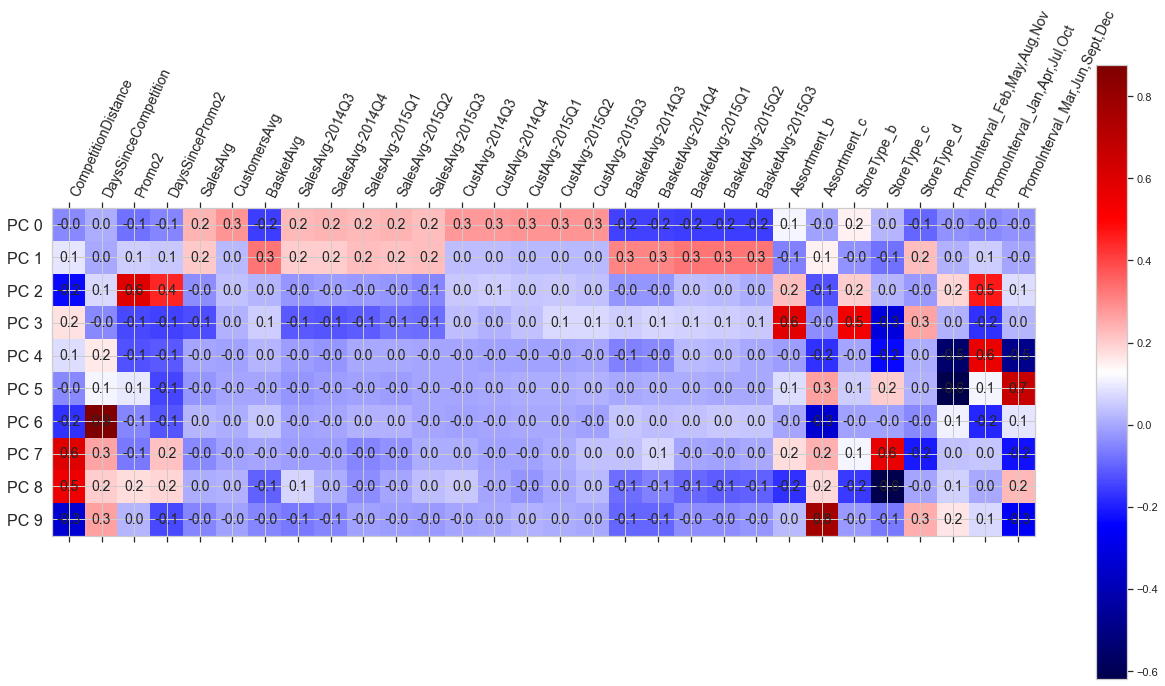

In [16]:
# Une façon plus user-friendly de voir ces relations...
principalDf = pd.DataFrame(data = X_pca).rename(columns={i: "PC "+str(i) for i in range(X_pca.shape[1])})
finalDf = pd.concat([principalDf.reset_index(), data.reset_index()], axis = 1)

plt.figure(figsize=(22,11))
plt.matshow(pca.components_, cmap='seismic', fignum=1,)
for (i, j), z in np.ndenumerate(pca.components_):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=14)
plt.yticks(range(X_pca.shape[1]),["PC "+str(i) for i in range(X_pca.shape[1])],fontsize=16)
plt.colorbar()
plt.xticks(range(len(data_pca.columns)),data_pca.columns,rotation=65,ha='left', fontsize=14)

plt.show()

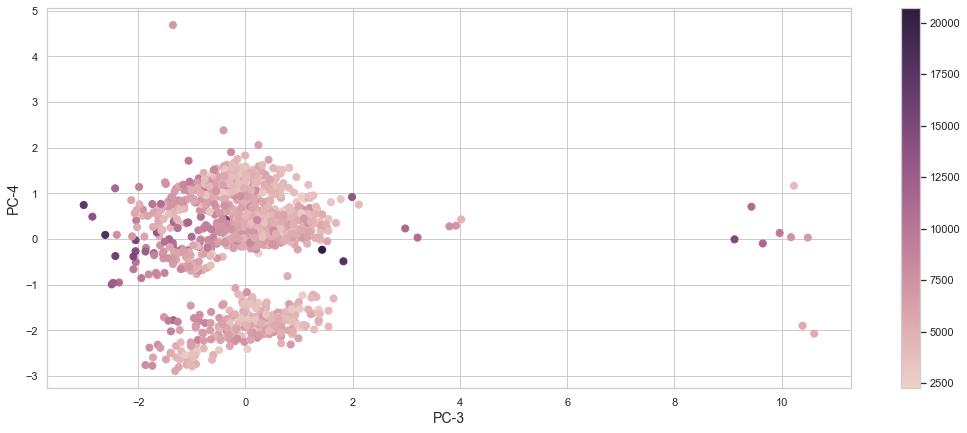

In [17]:
# Nuage de points des différents magasins en fonction des composantes principales (axes) et des ventes moyennes (couleur)

df_plot_pca = pd.DataFrame(X_pca)
df_plot_pca["SalesAvg"] = data["SalesAvg"]

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(18,7))

## Choisir les Composantes principales en X et en Y
x_pc = 3
y_pc = 4
points = ax.scatter(x=df_plot_pca[x_pc], 
                    y=df_plot_pca[y_pc], 
                    c=df_plot_pca["SalesAvg"], 
                    s=50, 
                    cmap=cmap)
plt.xlabel("PC-"+str(x_pc), fontsize=14)
plt.ylabel("PC-"+str(y_pc), fontsize=14)
f.colorbar(points);

En pratique, on peut utiliser l'ACP pour "écrire" le jeu de données initial dans un nouvel espace qui "maximise la variance" et où chaque feature est linéairement indépendante des autres. <br> Ce nouveau data set est ensuite utilisé pour entrainer des modèles de régression ou de classification, qui peuvent donner des résultats meilleurs comparés à ceux obtenus avec le data set initial.

# 3. K-means

In [18]:
from sklearn.cluster import KMeans

In [21]:
data_cluster = data.copy()
data_cluster = data_cluster.drop("Store", axis=1)

# Normalisation
cols_scale = list(data_cluster.columns)
scaler = StandardScaler()
data_cluster[cols_scale] = scaler.fit_transform(data_cluster[cols_scale])

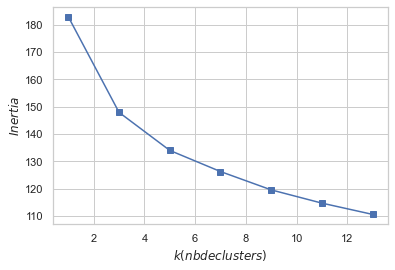

In [22]:
# Elbow method pour choisir le nombre des clusters
inertia = []
for k in range(1, 15, 2):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_cluster)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 15, 2), inertia, marker='s');
plt.xlabel('$k (nb de clusters)$')
plt.ylabel('$Inertia$');

In [23]:
# Clustering avec Nb_clusters
Nb_clusters = 6
kmeans = KMeans(n_clusters=Nb_clusters, random_state=1).fit(data_cluster)

In [24]:
# Ajout des Labels de cluster pour chaque store (ie à quel cluster appartient chaque store ?) au data set initial
data["Cluster"] = kmeans.labels_
data.head()

,Store,CompetitionDistance,DaysSinceCompetition,Promo2,DaysSincePromo2,SalesAvg,CustomersAvg,BasketAvg,SalesAvg-2014Q3,SalesAvg-2014Q4,SalesAvg-2015Q1,SalesAvg-2015Q2,SalesAvg-2015Q3,CustAvg-2014Q3,CustAvg-2014Q4,CustAvg-2015Q1,CustAvg-2015Q2,CustAvg-2015Q3,BasketAvg-2014Q3,BasketAvg-2014Q4,BasketAvg-2015Q1,BasketAvg-2015Q2,BasketAvg-2015Q3,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Cluster
0,1,"1,270.00","2,524.00",0,541.08,"3,945.70",467.65,8.39,"3,695.72","4,421.47","3,835.04","3,581.16","3,911.81",434.47,506.23,461.13,411.31,452.39,8.46,8.68,8.28,8.65,8.60,0,0,0,1,0,0,0,0,0
1,2,570.00,"2,829.00",1,"1,950.00","4,122.99",486.05,8.41,"4,152.05","4,439.93","4,179.44","4,058.76","4,315.00",505.32,493.71,476.14,465.67,541.06,8.24,8.85,8.66,8.61,8.23,0,0,0,0,0,0,1,0,0
2,3,"14,130.00","3,164.00",1,"1,579.00","5,741.25",620.29,9.12,"5,623.86","6,001.84","5,535.19","5,773.02","5,920.48",611.82,645.27,595.30,598.37,594.77,9.05,9.15,9.17,9.53,9.89,0,0,0,0,0,0,1,0,0
3,4,620.00,"2,159.00",0,748.86,"8,021.77","1,100.06",7.25,"8,307.22","8,732.13","8,058.19","8,018.45","8,933.39","1,111.37","1,171.97","1,104.79","1,065.33","1,127.26",7.44,7.41,7.26,7.48,7.89,0,1,0,1,0,0,0,0,4
4,5,"29,910.00",121.00,0,816.97,"3,867.11",444.36,8.61,"3,823.40","4,188.73","3,842.10","3,803.80","4,006.13",450.13,456.25,437.24,432.23,454.39,8.46,9.06,8.74,8.74,8.78,0,0,0,0,0,0,0,0,0


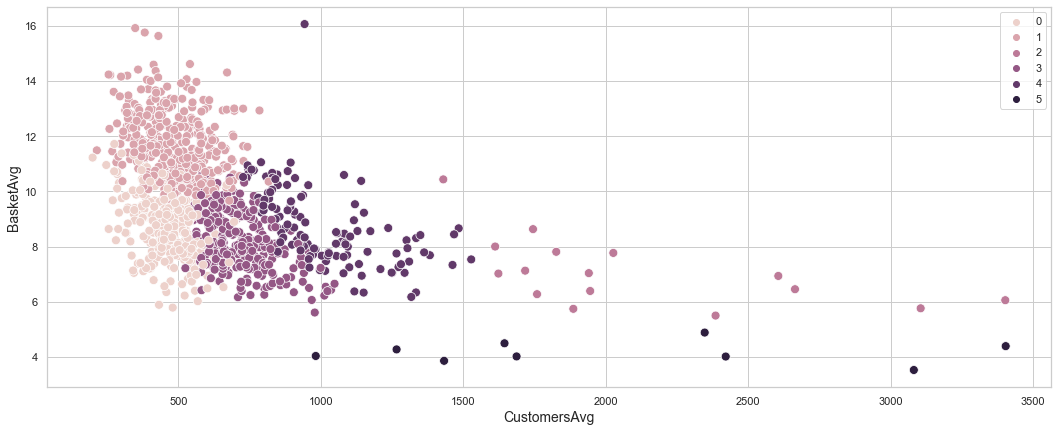

In [25]:
## Visualisation des clusters

# Changer les axes X et Y pour voir la répartition des clusters...
x_axis = "CustomersAvg"
y_axis = "BasketAvg"

plt.figure(figsize=(18,7))

sns.scatterplot(
    x = data[x_axis],
    y = data[y_axis],
    hue = data["Cluster"],
    s=80,
)

plt.xlabel(x_axis, fontsize=14)
plt.ylabel(y_axis, fontsize=14)
plt.legend()
plt.show()

Taille du cluster : 9, (1.0% des magasins)


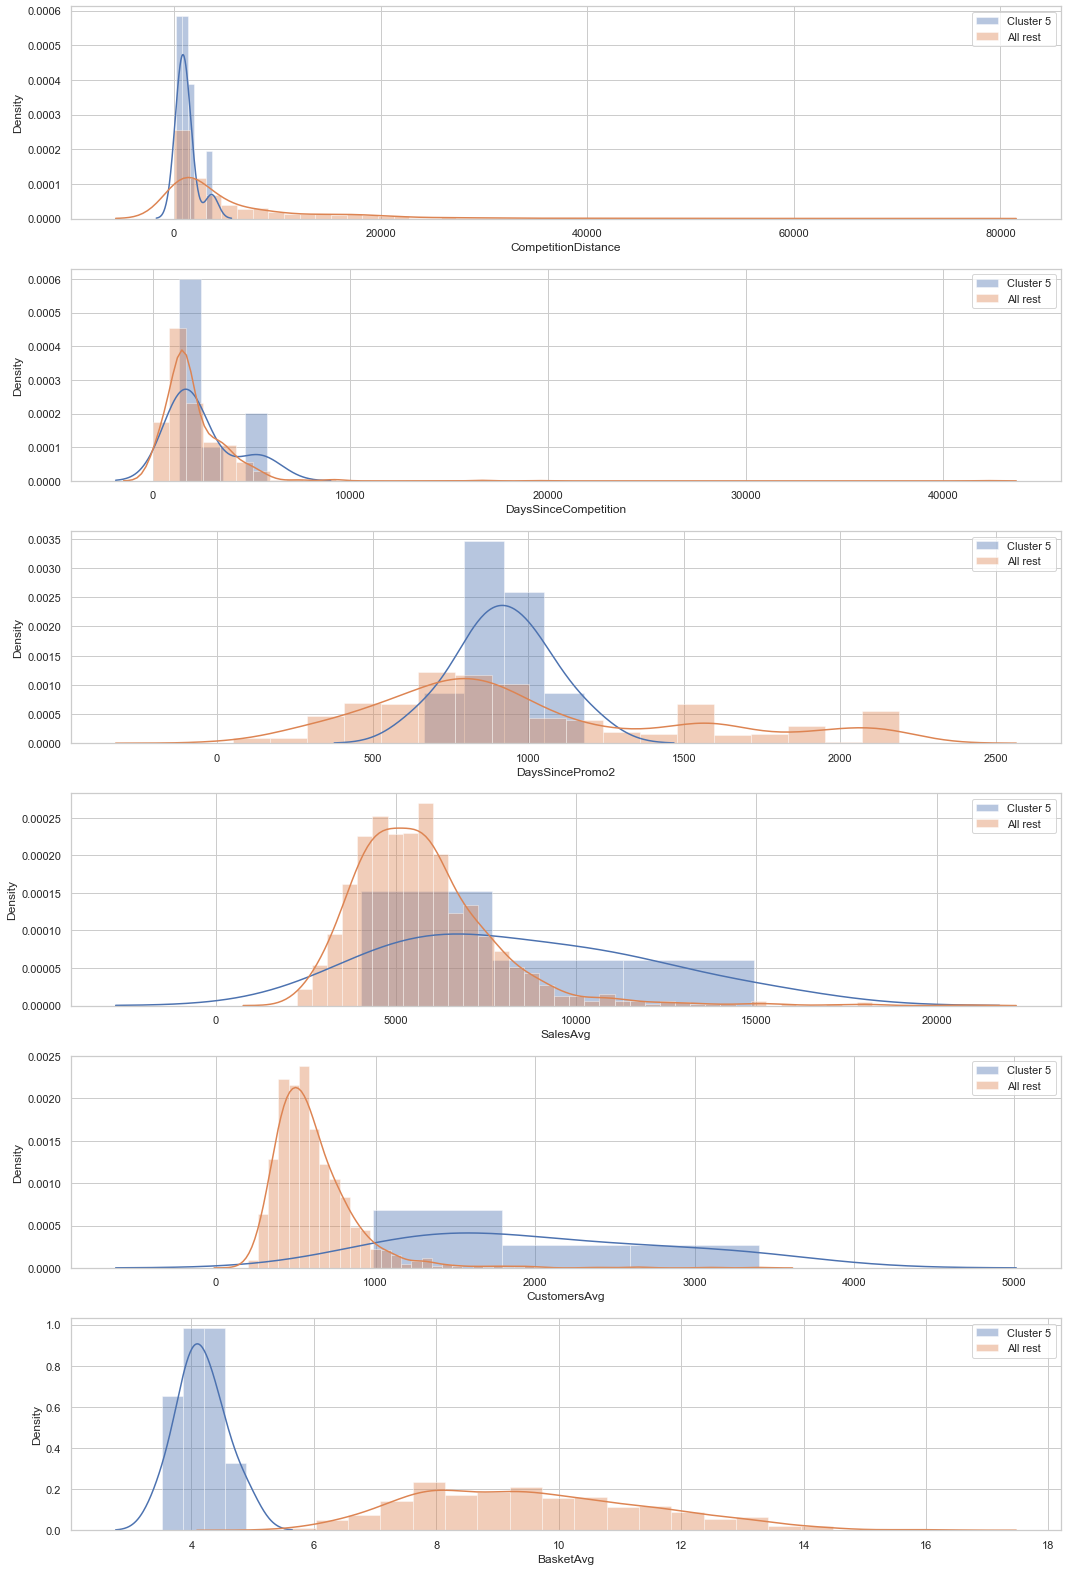

In [26]:
## Caractérisation de chaque cluster en regardant les distributions des variables dans le clusters VS ailleurs

## A compléter par d'autres variables numériques ...
num_cols = ["CompetitionDistance", 
            "DaysSinceCompetition", 
            "DaysSincePromo2", 
            "SalesAvg", 
            "CustomersAvg", 
            "BasketAvg",
           ]

# Numéro du cluster (commence de 0)
n_cluster = 5
df_cluster = data[data.Cluster==n_cluster]
df_others = data[data.Cluster!=n_cluster]

print("Taille du cluster : {}, ({}% des magasins)".format(len(df_cluster), np.round(100*len(df_cluster)/len(data))))

 
f, ax = plt.subplots(6, 1, figsize=(15,22))  ## Changer le nombre de subplots si vous rajoutez des colonnes dans num_cols
for i in range(len(num_cols)) :  
    sns.distplot(df_cluster[num_cols[i]], hist=True, label="Cluster " + str(n_cluster), ax=ax[i])
    sns.distplot(df_others[num_cols[i]], hist=True, label="All rest", ax=ax[i])    

#     sns.histplot(x=df_cluster[num_cols[i]], stat = "probability", label="Cluster " + str(n_cluster), color="blue", alpha=0.5, ax=ax[i])
#     sns.histplot(x=df_others[num_cols[i]], stat = "probability", label="All rest", color="red", alpha=0.5, ax=ax[i])
    ax[i].legend()


plt.tight_layout()
plt.show()

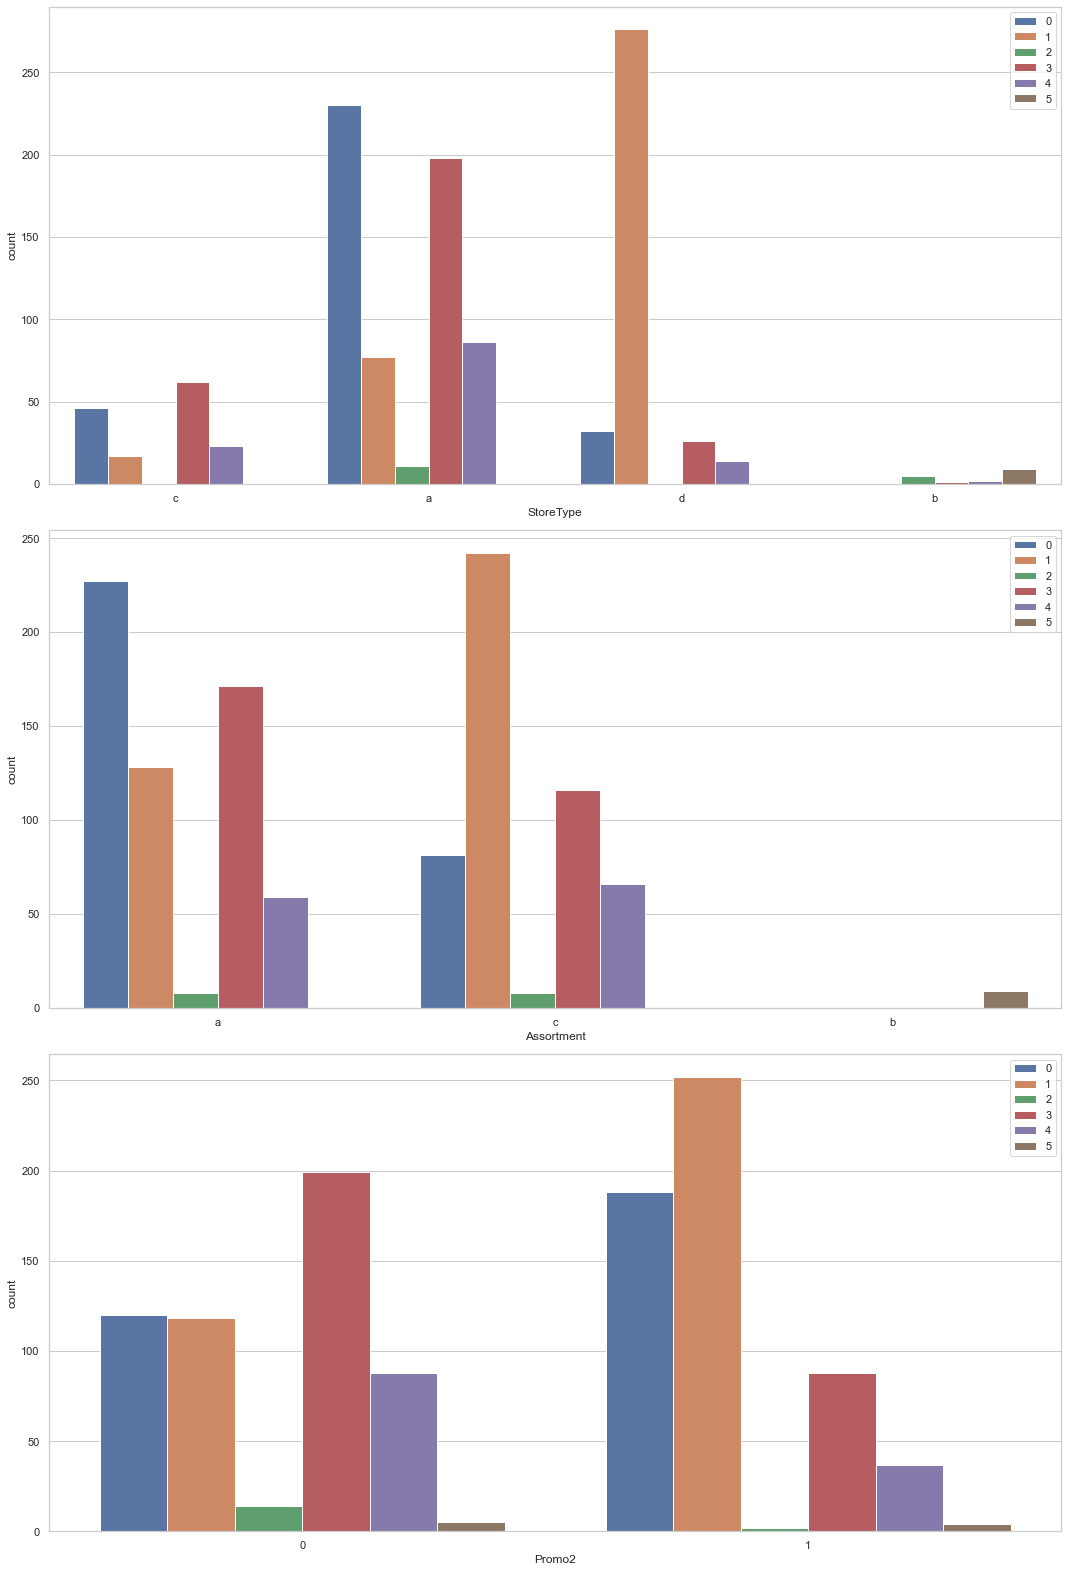

In [27]:
## Diff avec var catégorielle
data_with_categorical["Cluster"] = kmeans.labels_

## A compléter par d'autres variables numériques ...
cat_cols = [
    "StoreType",
    "Assortment",
    "Promo2"    
]

f, ax = plt.subplots(3, 1, figsize=(15,22))
for i in range(len(cat_cols)) :  
    sns.countplot(
        data = data_with_categorical, 
        x = cat_cols[i],
        hue = "Cluster",
        ax = ax[i],
    )
    ax[i].legend()


plt.tight_layout()
plt.show()